The code in this notebook is outdated. Not to be run.

This notebook inspect the model that uses distance sequence, enumeration distance sequence, fixed sequence, dwelling sequence, and similarity label. The models are:

* model 1: k = 7
* model 2: k = 7 & simple imputaion for numerical columns

Then feature importance is presented at the end. 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [32]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

In [33]:
print(filled_1850.shape)
print(filled_1850.loc[~filled_1850['block_num'].isnull()].shape)
print(filled_1850.loc[filled_1850['block_num'].isnull()].shape)

(515630, 32)
(166500, 32)
(349130, 32)


In [34]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

In [35]:
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")

In [36]:
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= "CENSUS_PAGENUM", right_on = "CENSUS_PAGENO_HOUSEHOLD")

In [37]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, fixed = True, distance = True)

In [41]:
similar_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]
census_enum_seq.apply_similarity(sim_columns=similar_cols)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 24272.0


In [9]:
def plot_predictions(cluster_of_centroid, ward, cluster, test_df, title=None):
    #colors = [color for color, i in zip(mcolors.CSS4_COLORS.values(), range(len(np.unique(self.clusters)))) if i < len(np.unique(self.clusters))]
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][x] for x in range(len(np.unique(cluster_of_centroid)))]
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    color = colors[0]

    # for cluster, color in zip(np.unique(cluster_of_centroid), colors):
        # get cluster data
    X_subset = test_df[test_df["pred_cluster"] == cluster]
    centroids_subset = np.array(list(block_centroids[ward].values()))[cluster_of_centroid == cluster]

    # graph info
    ax.scatter(x=test_df.loc[:, x_col], y=test_df.loc[:, y_col], s=1, alpha=0.8,
               color='grey')
    for clus, co in zip(np.unique(cluster_of_centroid), colors):
        if clus == cluster:
            size = 50
        else:
            size = 20
        X_subset_2 = X_subset[X_subset["cluster"] == clus]
        ax.scatter(x=X_subset_2.loc[:, x_col], y=X_subset_2.loc[:, y_col], s=size, alpha=0.8, label=str(clus),
                   color=co)
    #     ax.scatter(centroids_subset[:, 0], centroids_subset[:, 1], marker="*", s=80, color=co)
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title("Clustered block centroids, Ward {}, 1850".format(ward))

    ax.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")
    plt.show()

## Try with kmeans=7

There should be around 6-7 blocks in a cluster (as opposed to 7-9 when kmeans=5)

## model 1

In [10]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]

transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

n is 7 and it's the 10th iteration
n is 7 and it's the 20th iteration
n is 7 and it's the 30th iteration
n is 7 and it's the 40th iteration
n is 7 and it's the 50th iteration


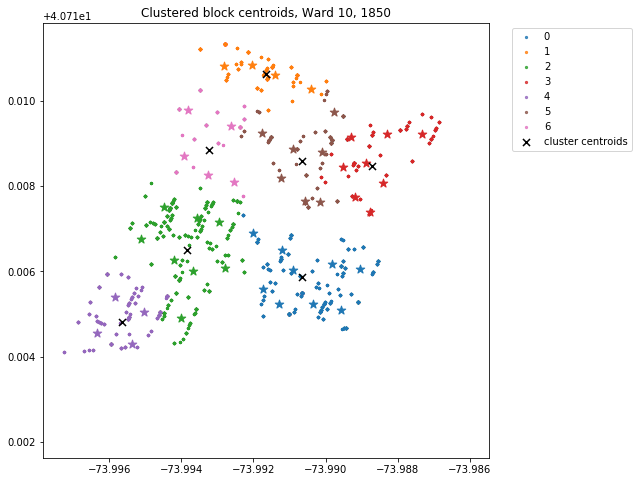

In [11]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                             KMeans(7), block_centroids)
score, model = interpolate_sequences.kmeans_best(7)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [12]:
## retrain model using kmodes result

interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Cross Validation
avg Training score: 0.98081343182539
Test score: [0.6064623032311516, 0.538955087076077, 0.4849557522123894, 0.6343692870201096, 0.6053604436229205, 0.6020036429872495, 0.6361464968152867, 0.5909465020576131, 0.6411960132890365, 0.5709251101321586]
avg Test score: 0.5911320638443992


In [14]:
train_1,test_1 = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train_1, test_1)

In [15]:
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 0.9846519671422396
Test score: 0.6064623032311516


In [16]:
test_1['pred_cluster'] = interpolate_sequences.model.predict(test_1)

In [17]:
test_1.groupby(['cluster', 'block_num'])['pred_cluster'].agg('count')

cluster  block_num
0        188.0         64
         189.0         27
         190.0         39
         195.0         35
         1265.0        13
         1266.0        96
         1267.0         9
         1268.0        19
1        200.0          7
         201.0         74
         1282.0        16
         1283.0        18
2        186.0         49
         187.0         25
         191.0        109
         192.0         90
         1260.0        28
         1263.0        16
         1270.0        43
         1271.0        19
3        196.0         19
         197.0         22
         203.0         50
         1277.0         4
         1285.0        41
4        184.0         76
         185.0         22
         1259.0        24
5        198.0         62
         1274.0        27
         1279.0         9
         1280.0        12
6        193.0          7
         1272.0         5
         1281.0        31
Name: pred_cluster, dtype: int64

## model 2

In [19]:
from sklearn.impute import SimpleImputer

In [38]:
census_enum_seq.df['processed_page_line'] = census_enum_seq.df['CENSUS_PAGENUM'] * 1000 + census_enum_seq.df['CENSUS_LINE']
census_enum_seq.data['processed_page_line'] = census_enum_seq.data['CENSUS_PAGENUM'] * 1000 + census_enum_seq.df['CENSUS_LINE']

In [50]:
all_cols = ["CENSUS_SERIALB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_NAMELAST", 
            'CENSUS_DWELLING_SEQ']

one_hot_cols = ['similarity_label']
numerical_cols = ["sequence_id", 'enum_dist_order', 'dwelling_seq_id', 
                  'dwelling_seq_id','fixed_seq', 'enum_dist_id', 'enum_dist_order', 'processed_page_line']

transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),
                                              ('numerical', SimpleImputer(strategy='constant', fill_value=-10), numerical_cols)
                                             ])

# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

n is 7 and it's the 10th iteration
n is 7 and it's the 20th iteration
n is 7 and it's the 30th iteration
n is 7 and it's the 40th iteration
n is 7 and it's the 50th iteration


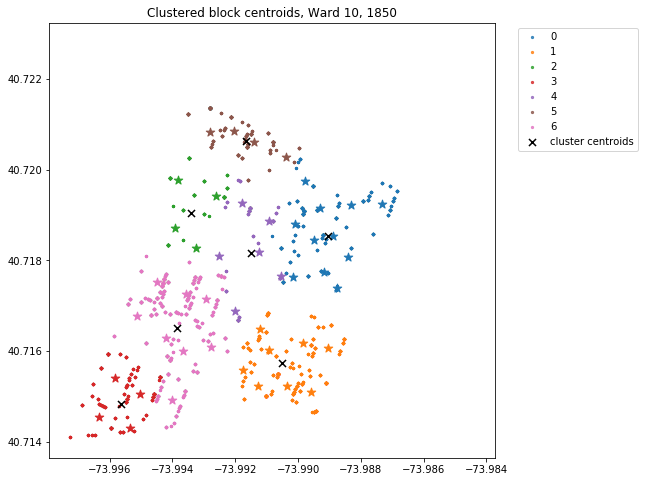

In [51]:
interpolate_sequences_2 = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                             KMeans(7), block_centroids)
interpolate_sequences_2.df['enum_dist_id'] = np.where(interpolate_sequences_2.df['enum_dist_id'] == 'Ward_Num', 
                                                      -10, interpolate_sequences_2.df['enum_dist_id']).tolist()


score_2, model_2 = interpolate_sequences_2.kmeans_best(7)
interpolate_sequences_2.set_clustering_algo(model_2)
interpolate_sequences_2.apply_clustering(algo_fit = True)
interpolate_sequences_2.clustervis(kmeans = True)

In [52]:
## retrain model using kmodes result

interpolate_sequences_2.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences_2.train_score).mean())
print('Test score:', interpolate_sequences_2.test_score)
print("avg Test score:", np.array(interpolate_sequences_2.test_score).mean())

Cross Validation
avg Training score: 0.9208531634371641
Test score: [0.5513937282229965, 0.5392077607113985, 0.5270150575730735, 0.6350639578630549, 0.5541044776119403, 0.5143626570915619, 0.5034377387318564, 0.4762645914396887, 0.5016611295681063, 0.4898336414048059]
avg Test score: 0.5292344740218483


### Refit the model using this setting (no CV) [CV score of the model is 0.63]

* Similar performance when using k = 7, but has fewer block members in a cluster
* The results from here are used for further analysis.

In [ ]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)

In [ ]:
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

In [ ]:
test['pred_cluster'] = interpolate_sequences.model.predict(test)

In [ ]:
interpolate_sequences.clusters

In [ ]:
# if self.clusters is None:
#     raise AttributeError("Please run apply clustering first")

cluster_of_centroid = interpolate_sequences.clusters.copy()
ward = 10
cluster = 0
test_df = test


for c in range(7):
    title = 'true cluster ' + str(c)
    plot_predictions(cluster_of_centroid, ward, c, test_df, title)

The plot shows all records that are predicted as C cluster. For instance, `predicted cluster 0` plot shows all census records that the model predicts as in cluster 0. The biggest marks are correct prediction. The smaller ones are mispredictions and the grey ones are other Census records that are present in the test data.


In [ ]:
test['cluster'].value_counts().sort_index()

In [ ]:
c1 = test.groupby(['cluster', 'pred_cluster'], as_index=False)['CENSUS_SERIALB'].agg('count')
ctotal = test.groupby('cluster', as_index=False)['CENSUS_SERIALB'].agg('count')

c_per = c1.merge(ctotal, how='left', on='cluster')
c_per['percent'] = c_per['CENSUS_SERIALB_x']/c_per['CENSUS_SERIALB_y']*100
c_per.drop(columns=['CENSUS_SERIALB_x', 'CENSUS_SERIALB_y'])
pd.pivot_table(c_per, values='percent', index='cluster',
                    columns=['pred_cluster'], fill_value=0)

## Feature Importance -- target encoded sequences

* sequence id and enum distance seq are the top 2 most importance sequences
* similarity label 9 and 12 are the fourth and the fift importance features

In [ ]:
importance_df = pd.DataFrame({'feature': interpolate_sequences.model.named_steps["preprocess"].get_feature_names(),
                             'importance': interpolate_sequences.model.named_steps["classifier"].feature_importances_})
cut_importance = importance_df.sort_values('importance').tail(20)

In [ ]:
archive.graph_coefs(cut_importance['feature'], 
                    cut_importance['importance'],
                    "XGBoost Feature Importances Centroid Prediction")

## How similary are two records that are correctly and wrongly predicted?

### In cluster 2 - block num 192

* [2461] and [2465]: squences and similarity are not the strong predictive features. Records are classified into different clusters even when they have the same values of those features.
* [12275] and [13965]: also proves the point above. They are classified inot the same cluster even tho they have different values of those features.

In [ ]:
test.reset_index(inplace=True)
test.loc[(test['cluster']==2) & (test['pred_cluster']!=2)][similar_cols + ['similarity_label', 'cluster', 'pred_cluster', 'block_num']].drop_duplicates()

In [ ]:
pd.set_option('display.max_columns', None)
test.iloc[[1251,490],:][all_cols + similar_cols + ['similarity_label', 'cluster', 'pred_cluster', 'block_num']].drop_duplicates()

In [ ]:
test.shape

In [ ]:
test['enum_dist_order'].unique()

In [ ]:
all_cols

In [ ]:
test.loc[(test['cluster']==2) &
        (test['block_num']==192)][similar_cols + ['similarity_label', 'cluster', 'pred_cluster', 'block_num']].drop_duplicates()

### In cluster 4 - block num 186

* Records in the same block numbers have totally different sequences so from the model perspective, this misclassification is not wrong. Sequences and similarity may not be enough for correct classification.
* cluster 1 is the most unclear cluster (analysis not shown in this notebook). The label is not unique (or closely unique) for any block cluster.

In [ ]:
##Wrong classification of block num 186 (cluster 4)
test.loc[(test['cluster']==4) & 
         (test['pred_cluster']==6)][similar_cols + ['similarity_label', 'cluster', 'pred_cluster', 'block_num']].drop_duplicates()

In [ ]:
## Correct classification of block num 186 (cluster 4)
test.loc[(test['cluster']==4) & 
         (test['pred_cluster']==4) &
        (test['block_num']==186)][similar_cols + ['similarity_label', 'cluster', 'pred_cluster', 'block_num']].drop_duplicates()

## Is it impactfully wrong to treat sequences as numerical values?

* could it be why sequences, and consequently similarity, are not strong indicator of block cluster?
* Treating as numerical should not be a problem bc we use XGBoost which is non-linear. The problem is when the same value of a feature points to different clusters. This happens due to using *TargetEncode*.

In [ ]:
for c in similar_cols:
    print('unique values of {}: {}'.format(c, interpolate_sequences.df[c].unique().shape[0]))

There are total of ~380 levels of features. Treating them all as categorical values (not using TargetEncode) will add ~380 more columns to the dataframe. This should be insignificant compared to the number of records in the dataframe.

In [ ]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
             "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "enum_dist_order"]

one_hot_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id", 'similarity_label']
transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_cols)])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

In [ ]:
census_enum_seq.df[one_hot_cols].dtypes
for c in one_hot_cols:
    census_enum_seq.df[c] = census_enum_seq.df[c].astype(str)
census_enum_seq.df[one_hot_cols].dtypes

In [ ]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + one_hot_cols,
                                             KMeans(7), block_centroids)
score, model = interpolate_sequences.kmeans_best(7)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [ ]:
## retrain model using kmodes result

interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

## Feature Importance - one hot sequences

* some ids of `sequence_id` (x0) and `fixed_seq` (x3) appear in the top 20 important features

In [ ]:
from interpolation import archive

In [ ]:
importance_df = pd.DataFrame({'feature': interpolate_sequences.model.named_steps["preprocess"].get_feature_names(),
                             'importance': interpolate_sequences.model.named_steps["classifier"].feature_importances_})
cut_importance = importance_df.sort_values('importance').tail(20)

In [ ]:
archive.graph_coefs(cut_importance['feature'], 
                    cut_importance['importance'],
                    "XGBoost Feature Importances Centroid Prediction")

In [ ]:
one_hot_cols